In [51]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [52]:
import numpy as np
import pandas as pd

In [53]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM


In [54]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [55]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite",echo=False)

In [56]:
### reflect an existing database into a new model
Base = automap_base()
### reflect the tables
Base.prepare(engine, reflect=True)

In [57]:
### We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [58]:
### Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [59]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [83]:
### Design a query to retrieve the last 12 months of precipitation data and plot the results
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

### Get the first element of the tuple
max_date = max_date[0]
max_date

'2017-08-23'

In [84]:
### Calculate the date 1 year ago from the last data point in the database

year_ago = dt.datetime.strptime(max_date, "%Y-%m-%d") - dt.timedelta(days=366)

year_ago

datetime.datetime(2016, 8, 22, 0, 0)

In [62]:
### Perform a query to retrieve the data and precipitation scores
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= year_ago).all()

In [88]:
### Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df = pd.DataFrame(query,columns=['date', 'precipitation'])

#precipitation_df

In [89]:
### Sort the dataframe by date

precipitation_df = precipitation_df.sort_values(by='date',ascending=True)


print (precipitation_df.head(1))
print (precipitation_df.tail(1))




         date  precipitation
0  2016-08-23            0.0
            date  precipitation
2229  2017-08-23           0.45


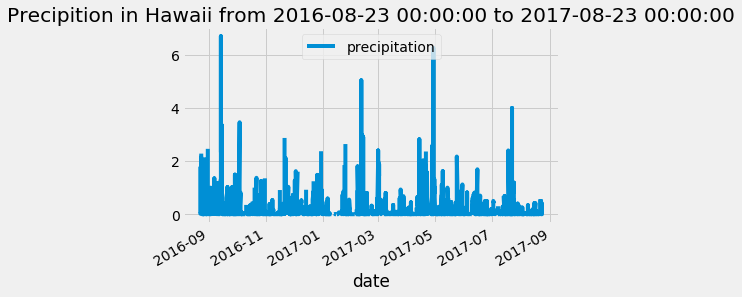

In [91]:
### Use Pandas Plotting with Matplotlib to plot the data
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'], format='%Y-%m-%d')
precipitation_df.set_index('date', inplace=True)
precipitation_df .plot(title="")
plt.legend(loc='upper center')
plt.title("Precipition in Hawaii from %s to %s" % (precipitation_df.index.min(),precipitation_df.index.max()))
plt.savefig("Precipitation in Hawaii.png")
plt.show()

In [92]:
### Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [93]:
### Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
print(f'There are {stations} stations available in this dataset.')

There are 9 stations available in this dataset.


In [94]:
### What are the most active stations? (i.e. what stations have the most rows)?
### List the stations and the counts in descending order.
station=pd.DataFrame(session.query(Measurement.station, func.count(Measurement.station).label('count')).\
                                  group_by(Measurement.station).\
                                  order_by('count DESC').all(),columns=["Station","No. of Measurements"])
station

,Station,No. of Measurements
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [95]:

### Using the station id from the previous query, calculate the lowest temperature recorded, 
### highest temperature recorded, and average temperature most active station?
most_active_station = session.query(Measurement.station, 
                                    func.count(Measurement.station).label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count DESC').limit(1)[0][0]
                                    

sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
                
session.query(*sel).filter(Measurement.station==most_active_station).all()

[(54.0, 85.0, 71.66378066378067)]

In [96]:
### Choose the station with the highest number of temperature observations.
most_temps_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
most_temps_station= most_temps_station[0]
most_temps_station

'USC00519281'

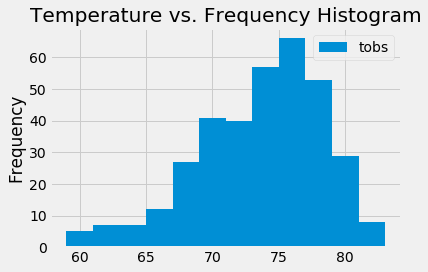

In [97]:
### Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_observations = session.query( Measurement.tobs).filter(Measurement.date >= year_ago).filter(Measurement.station == most_temps_station).all()
temperature_observations = pd.DataFrame(temperature_observations, columns=['tobs'])

temperature_observations.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.tight_layout()
plt.savefig("TemperaturevsFrequency.png")
plt.show()

In [98]:
### This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
### and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

### function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [99]:
### Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
### for your trip using the previous year's data for those same dates.
trip = calc_temps('2017-07-01','2017-07-14')
trip

[(69.0, 78.11627906976744, 87.0)]

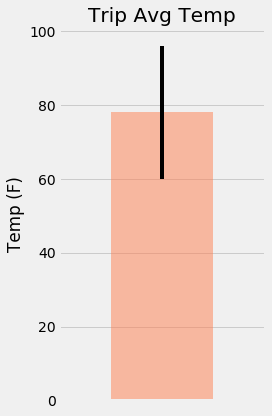

In [100]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


trip_temp_df = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

trip_temp_df.plot.bar(y='tavg', yerr=(trip_temp_df['tmax'] - trip_temp_df['tmin']), title='Trip Avg Temp', color='coral', alpha=0.5, figsize=(4,6))
plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.gca().legend_.remove()
plt.savefig("TripAvgTemp.png")
plt.show()

In [101]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

def precipitation(start_date, end_date):
    
    sel = [Measurement.station, 
           Station.name, 
           Station.latitude, 
           Station.longitude, 
           Station.elevation, 
           Measurement.prcp]
    
    return session.query(*sel).\
            filter(Measurement.station == Station.station).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).group_by(Measurement.station).order_by(Measurement.prcp.desc()).all()

precipitation_df = pd.DataFrame(precipitation('2017-07-01', '2017-07-14'))

precipitation_df

#print(precipitation('2017-07-01','2017-07-14'))

,station,name,latitude,longitude,elevation,prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.10
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.08
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.06
3,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,NaN
5,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,NaN
